# Convolutional Autoencoders

Convolutional autoencoders excel at processing images for the same reason that convolutional neural networks (CNNs) excel at image classification: they treat images as images rather than as mere collections of pixel values. Convolutional autoencoders enjoy a variety of uses, including removing noise from images and deblurring images. Let's demonstrate by building a pair of convolutional autoencoders and putting them to work on MNIST digits dataset. Begin by loading the dataset and dividing all the pixel values by 255.

In [1]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255
x_test = x_test / 255

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


Plot the first 30 digits in the dataset.

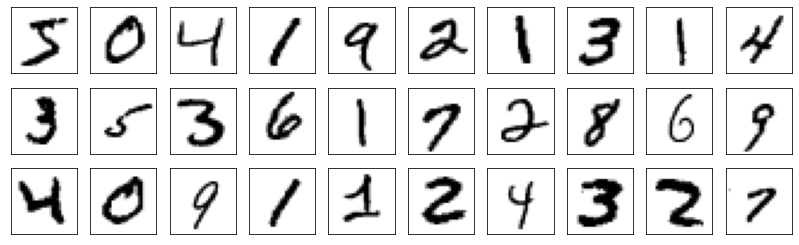

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 10, figsize=(14, 4.2), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i], cmap=plt.cm.gray_r)

Now let's have some fun with these digits.

## Denoising autoencoders

The first example demonstrates how convolutional autoencoders can be used to remove noise from images. The big idea is that we train the autoencoder with noisy images as the features and "clean" images as the targets, or desired outcomes. To that end, use a random-number generator to add noise to all the images and plot the noisy versions of the same 30 digits.

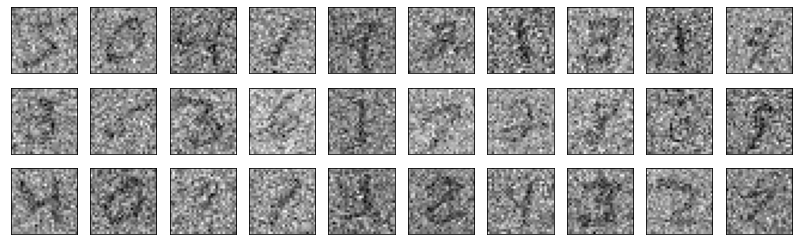

In [3]:
import numpy as np

np.random.seed(0)
x_train_noisy = np.random.normal(x_train, 0.7)
x_test_noisy = np.random.normal(x_test, 0.7)

fig, axes = plt.subplots(3, 10, figsize=(14, 4.2), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(x_train_noisy[i], cmap=plt.cm.gray_r)

The digits are barely recognizable, but perhaps an autoencoder can help with that. Create a convolutional autoencoder that reduces each image to 32 dimensions and then restores the original 784 dimensions. Note the [Conv2DTranspose](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/) layers (also known as *deconvolution layers*), which do just the opposite of [ConvD](https://keras.io/api/layers/convolution_layers/convolution2d/) layers. Also note that for speed and efficiency, we're using `strides=2` in the convolution layers in lieu of separate [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/) and [UpSampling2D](https://keras.io/api/layers/reshaping_layers/up_sampling2d/) layers to increase and decrease the size of images as they flow through the network.

In [4]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import GlobalAveragePooling2D

encoder = Sequential()
encoder.add(Conv2D(16, (3, 3), activation='relu', strides=2, padding='same', input_shape=(28, 28, 1)))
encoder.add(Conv2D(32, (3, 3), activation='relu', strides=2, padding='same'))
encoder.add(Conv2D(32, (3, 3), activation='relu', strides=2, padding='same'))
encoder.add(GlobalAveragePooling2D()) # 32

decoder = Sequential()
decoder.add(Dense(3 * 3 * 16, activation='relu'))
decoder.add(Reshape((3, 3, 16)))
decoder.add(Conv2DTranspose(32, (3, 3), strides=2, activation='relu'))
decoder.add(Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same'))
decoder.add(Conv2DTranspose(1, (3, 3), strides=2, activation='relu', padding='same'))
decoder.add(Reshape((28, 28)))

model = Sequential([encoder, decoder])
model.compile(loss='mse', optimizer='adam')

Train the model using `x_train_noisy` as the features and `x_train` as the targets.

In [5]:
hist = model.fit(x_train_noisy, x_train, epochs=20, validation_data=(x_test_noisy, x_test))

Epoch 1/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0467 - val_loss: 0.0346
Epoch 2/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0327 - val_loss: 0.0303
Epoch 3/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0295 - val_loss: 0.0279
Epoch 4/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0278 - val_loss: 0.0266
Epoch 5/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0267 - val_loss: 0.0260
Epoch 6/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0259 - val_loss: 0.0251
Epoch 7/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0253 - val_loss: 0.0247
Epoch 8/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0249 - val_loss: 0.0241
Epoch 9/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0245 - val_loss: 0.0240
Epoch 10/20
1875/1875 [==============================] - 10s 5ms/step - los

Plot the training and validation accuracy.

[]

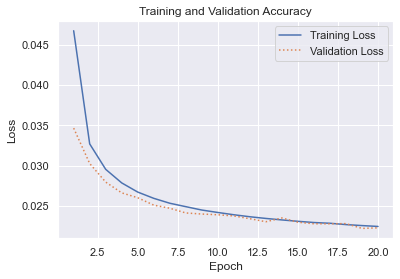

In [6]:
import seaborn as sns
sns.set()

err = hist.history['loss']
val_err = hist.history['val_loss']
epochs = range(1, len(err) + 1)

plt.plot(epochs, err, '-', label='Training Loss')
plt.plot(epochs, val_err, ':', label='Validation Loss')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.plot()

Test the model with 10 noisy digits from the test dataset.

1/1 [==============================] - 0s 106ms/step


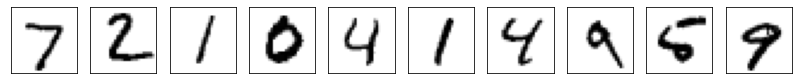

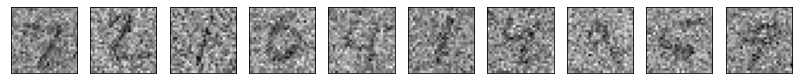

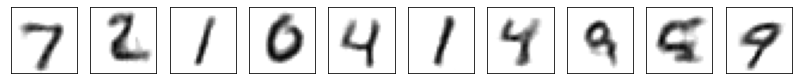

In [7]:
sns.reset_orig()
fig, axes = plt.subplots(1, 10, figsize=(14, 4), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(x_test[i], cmap=plt.cm.gray_r)

fig, axes = plt.subplots(1, 10, figsize=(14, 4), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(x_test_noisy[i], cmap=plt.cm.gray_r)

y = model.predict(x_test_noisy[:10])
fig, axes = plt.subplots(1, 10, figsize=(14, 4), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(y[i], cmap=plt.cm.gray_r)

Did the model perform adequately? Can you make out the digits on the bottom row?

## Deblurring autoencoders

Another use for convolutional autoencoders is sharpening blurry images. Let's build a convolutional autoencoder and use it to sharpen images in the MNIST digits dataset that were intentionally blurred. Start by using the Python Imaging Library (PIL) to blur all the images.

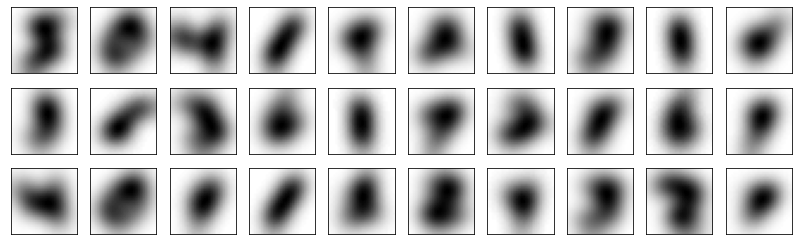

In [8]:
from PIL import Image, ImageFilter

gaussian_filter = ImageFilter.GaussianBlur(radius=4)
x_train_blurry = [Image.fromarray(x * 255.0).convert('L').filter(gaussian_filter) for x in x_train]
x_test_blurry = [Image.fromarray(x * 255.0).convert('L').filter(gaussian_filter) for x in x_test]
x_train_blurry = np.array([np.array(x) for x in x_train_blurry])
x_test_blurry = np.array([np.array(x) for x in x_test_blurry])

fig, axes = plt.subplots(3, 10, figsize=(14, 4.2), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(x_train_blurry[i], cmap=plt.cm.gray_r)

Create a convolutional autoencoder that's identical to the one in the previous example.

In [9]:
encoder = Sequential()
encoder.add(Conv2D(16, (3, 3), activation='relu', strides=2, padding='same', input_shape=(28, 28, 1)))
encoder.add(Conv2D(32, (3, 3), activation='relu', strides=2, padding='same'))
encoder.add(Conv2D(32, (3, 3), activation='relu', strides=2, padding='same'))
encoder.add(GlobalAveragePooling2D()) # 32

decoder = Sequential()
decoder.add(Dense(3 * 3 * 16, activation='relu'))
decoder.add(Reshape((3, 3, 16)))
decoder.add(Conv2DTranspose(32, (3, 3), strides=2, activation='relu'))
decoder.add(Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same'))
decoder.add(Conv2DTranspose(1, (3, 3), strides=2, activation='relu', padding='same'))
decoder.add(Reshape((28, 28)))

model = Sequential([encoder, decoder])
model.compile(loss='mse', optimizer='adam')

Train the model using `x_train_blurry` as the features and `x_train` as the targets.

In [10]:
hist = model.fit(x_train_blurry, x_train, epochs=20, validation_data=(x_test_blurry, x_test))

Epoch 1/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0331 - val_loss: 0.0233
Epoch 2/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0207 - val_loss: 0.0185
Epoch 3/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0182 - val_loss: 0.0167
Epoch 4/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0167 - val_loss: 0.0154
Epoch 5/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0157 - val_loss: 0.0146
Epoch 6/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0150 - val_loss: 0.0149
Epoch 7/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0144 - val_loss: 0.0142
Epoch 8/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0139 - val_loss: 0.0134
Epoch 9/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0135 - val_loss: 0.0127
Epoch 10/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0

Plot the training and validation accuracy.

[]

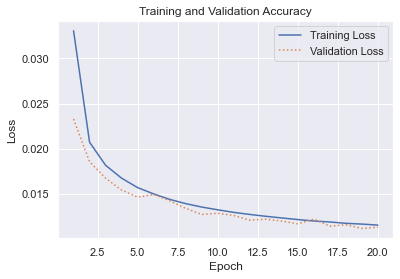

In [11]:
sns.set()
err = hist.history['loss']
val_err = hist.history['val_loss']
epochs = range(1, len(err) + 1)

plt.plot(epochs, err, '-', label='Training Loss')
plt.plot(epochs, val_err, ':', label='Validation Loss')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.plot()

Test the model with 10 blurred digits from the test dataset.

1/1 [==============================] - 0s 76ms/step


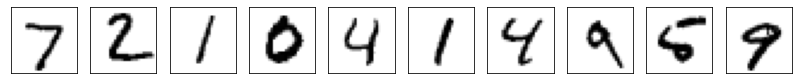

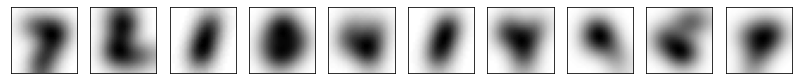

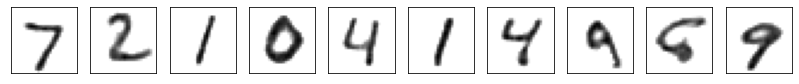

In [12]:
sns.reset_orig()
fig, axes = plt.subplots(1, 10, figsize=(14, 4), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(x_test[i], cmap=plt.cm.gray_r)

fig, axes = plt.subplots(1, 10, figsize=(14, 4), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(x_test_blurry[i], cmap=plt.cm.gray_r)

y = model.predict(x_test_blurry[:10])
fig, axes = plt.subplots(1, 10, figsize=(14, 4), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(y[i], cmap=plt.cm.gray_r)

Once more, can you make out the digits on the bottom row?

If you'd like to have some fun, try adding noise to the blurred images and see if an autoencoder can be trained to remove the blur *and* the noise.